In [1]:
import torch
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/PALA_data_InSilicoFlow.zip'
extract_path = '/content/ulm_data'

if not os.path.isfile(zip_path):
    print("ZIP file not found. Check the path:", zip_path)
else:
    os.makedirs(extract_path, exist_ok=True)
    # Only unzip if folder is empty (prevents re-unzipping every run)
    if len(os.listdir(extract_path)) == 0:
        !unzip -q "{zip_path}" -d "{extract_path}"
        print("Data unzipped successfully.")
    else:
        print("Data already extracted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data unzipped successfully.


In [11]:
seq = sio.loadmat('/content/ulm_data/PALA_data_InSilicoFlow/PALA_InSilicoFlow_sequence.mat')
seq.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BG', 'ConfigMedia', 'Control', 'CreateSubfolder', 'DUMMY', 'EF', 'Event', 'FullSavingPath', 'LEsys', 'ListPos', 'LogData', 'Media', 'P', 'PB', 'PData', 'P_end', 'P_media', 'P_preallocate', 'P_save', 'P_stack_IQ', 'P_stack_RF', 'Press2Run', 'Process', 'RcvProfile', 'Receive', 'Recon', 'ReconInfo', 'Resource', 'SG', 'SeqControl', 'TGC', 'TPC', 'TW', 'TX', 'TXEventCheckh', 'TX_Limits', 'Trans', 'UF', 'UIPos', 'UTA', 'VDAS', 'VDASupdates', 'VSX_Control', 'acqNb', 'action', 'ans', 'autoScriptTest', 'displayWindowTitle', 'filetitle', 'flag_SequenceEnded', 'fname', 'foldername', 'folderphantom', 'frameRateFactor', 'freeze', 'hv2GUIprofile', 'hvDefault', 'hvMax', 'i', 'ind', 'initialized', 'j', 'k', 'lambda', 'lx', 'ly', 'matfilePhantom', 'matfilenameRF', 'matfilenameRcvData', 'maxADRate', 'maxAcqDepth', 'maxCCH', 'minADRate', 'minTpcVoltage', 'nextRI', 'noConnES', 'nrows', 'nscJump', 'nscLoopCnt_rpt', 'nscLoopCnt_stack', 'nscLoopTest_rpt

In [34]:
gt = sio.loadmat('/content/ulm_data/PALA_data_InSilicoFlow/PALA_InSilicoFlow_v3_pos_Tracks_dt.mat')
gt.keys()

dict_keys(['__header__', '__version__', '__globals__', 'MyMedia', 'Tracks_dt'])

In [35]:
gt['Tracks_dt'][0, 0][0]

array([-7.38085854e+01, -2.73945595e-01,  4.03123400e+01,  7.31500000e+03])

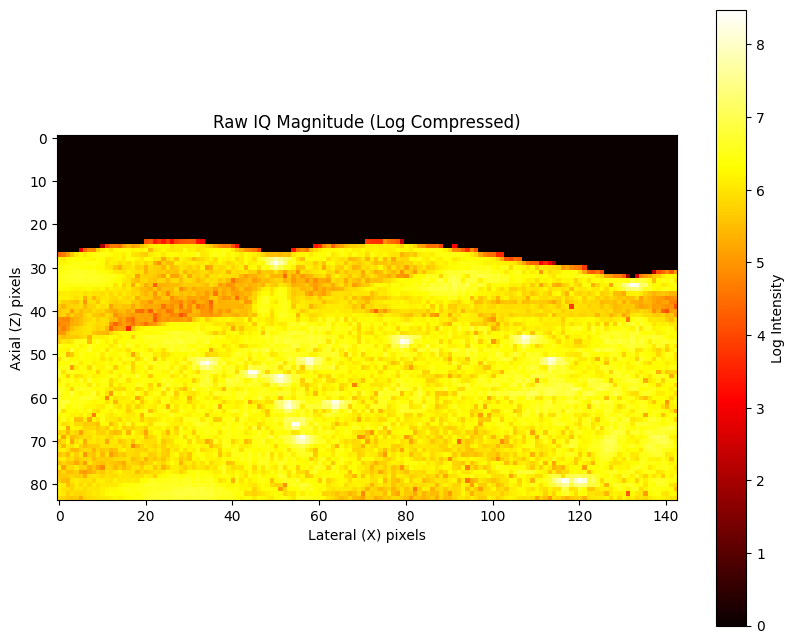

Frame Dimensions: (84, 143)


In [36]:
def plot_raw_iq_frame(file_path):
    mat_data = sio.loadmat(file_path)

    if 'IQ' in mat_data:
        # IQ data is complex. We take the absolute value to get intensity.
        # Shape is usually (Z, X, Frames)
        iq_complex = mat_data['IQ']

        # Take the first frame [:, :, 0] and calculate magnitude
        frame_intensity = np.abs(iq_complex[:, :, 0])

        # Log compression often helps visualize tiny microbubbles better
        frame_log = np.log10(frame_intensity + 1)

        plt.figure(figsize=(10, 8))
        plt.imshow(frame_log, cmap='hot')
        plt.title("Raw IQ Magnitude (Log Compressed)")
        plt.xlabel("Lateral (X) pixels")
        plt.ylabel("Axial (Z) pixels")
        plt.colorbar(label='Log Intensity')
        plt.show()

        print(f"Frame Dimensions: {frame_intensity.shape}")
    else:
        print(f"Variable 'IQ' not found. Available keys: {mat_data.keys()}")

# Run this on your IQ file
plot_raw_iq_frame('/content/ulm_data/PALA_data_InSilicoFlow/IQ/PALA_InSilicoFlow_IQ001.mat')

In [37]:
mat_path = "/content/ulm_data/PALA_data_InSilicoFlow/PALA_InSilicoFlow_sequence.mat"
data = sio.loadmat(mat_path)

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'BG', 'ConfigMedia', 'Control', 'CreateSubfolder', 'DUMMY', 'EF', 'Event', 'FullSavingPath', 'LEsys', 'ListPos', 'LogData', 'Media', 'P', 'PB', 'PData', 'P_end', 'P_media', 'P_preallocate', 'P_save', 'P_stack_IQ', 'P_stack_RF', 'Press2Run', 'Process', 'RcvProfile', 'Receive', 'Recon', 'ReconInfo', 'Resource', 'SG', 'SeqControl', 'TGC', 'TPC', 'TW', 'TX', 'TXEventCheckh', 'TX_Limits', 'Trans', 'UF', 'UIPos', 'UTA', 'VDAS', 'VDASupdates', 'VSX_Control', 'acqNb', 'action', 'ans', 'autoScriptTest', 'displayWindowTitle', 'filetitle', 'flag_SequenceEnded', 'fname', 'foldername', 'folderphantom', 'frameRateFactor', 'freeze', 'hv2GUIprofile', 'hvDefault', 'hvMax', 'i', 'ind', 'initialized', 'j', 'k', 'lambda', 'lx', 'ly', 'matfilePhantom', 'matfilenameRF', 'matfilenameRcvData', 'maxADRate', 'maxAcqDepth', 'maxCCH', 'minADRate', 'minTpcVoltage', 'nextRI', 'noConnES', 'nrows', 'nscJump', 'nscLoopCnt_rpt', 'nscLoopCnt_stack', 'nscLoopTest_rpt

In [38]:
seq = sio.loadmat('/content/ulm_data/PALA_data_InSilicoFlow/PALA_InSilicoFlow_sequence.mat')
seq.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BG', 'ConfigMedia', 'Control', 'CreateSubfolder', 'DUMMY', 'EF', 'Event', 'FullSavingPath', 'LEsys', 'ListPos', 'LogData', 'Media', 'P', 'PB', 'PData', 'P_end', 'P_media', 'P_preallocate', 'P_save', 'P_stack_IQ', 'P_stack_RF', 'Press2Run', 'Process', 'RcvProfile', 'Receive', 'Recon', 'ReconInfo', 'Resource', 'SG', 'SeqControl', 'TGC', 'TPC', 'TW', 'TX', 'TXEventCheckh', 'TX_Limits', 'Trans', 'UF', 'UIPos', 'UTA', 'VDAS', 'VDASupdates', 'VSX_Control', 'acqNb', 'action', 'ans', 'autoScriptTest', 'displayWindowTitle', 'filetitle', 'flag_SequenceEnded', 'fname', 'foldername', 'folderphantom', 'frameRateFactor', 'freeze', 'hv2GUIprofile', 'hvDefault', 'hvMax', 'i', 'ind', 'initialized', 'j', 'k', 'lambda', 'lx', 'ly', 'matfilePhantom', 'matfilenameRF', 'matfilenameRcvData', 'maxADRate', 'maxAcqDepth', 'maxCCH', 'minADRate', 'minTpcVoltage', 'nextRI', 'noConnES', 'nrows', 'nscJump', 'nscLoopCnt_rpt', 'nscLoopCnt_stack', 'nscLoopTest_rpt

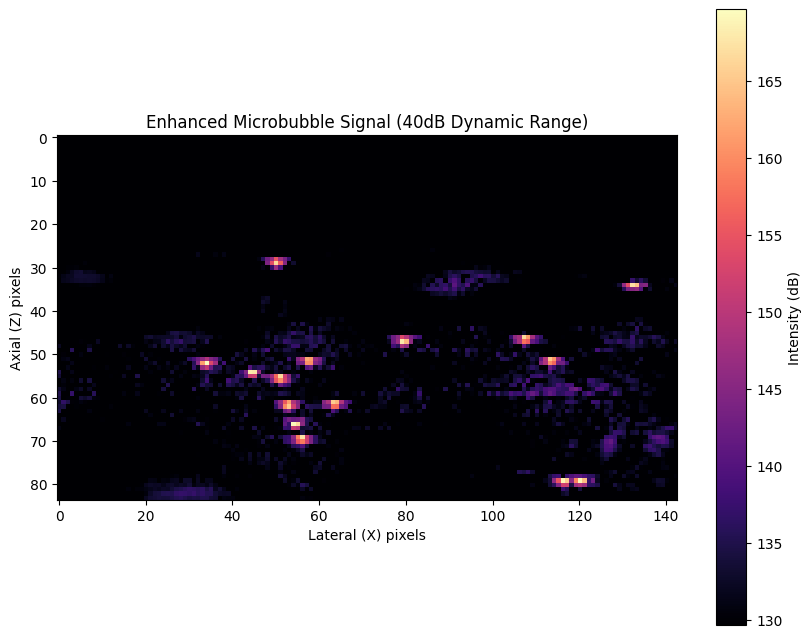

Max signal: 169.62 dB


In [47]:
def plot_enhanced_ulm_frame(file_path):
    mat_data = sio.loadmat(file_path)

    if 'IQ' in mat_data:
        # 1. Extract raw IQ and take Magnitude (Envelope Detection)
        iq_complex = mat_data['IQ']
        frame_intensity = np.abs(iq_complex[:, :, 0]) # First frame

        # 2. Log Compression (Critical for Ultrasound)
        # 20 * log10 is the standard for decibel (dB) scaling
        frame_db = 20 * np.log10(frame_intensity + 1e-6) # Added epsilon to avoid log(0)

        # 3. Dynamic Range Clipping
        # We only want the top 30-40 dB of the signal.
        # Anything below 'max - 40dB' is likely just noise.
        v_max = np.max(frame_db)
        v_min = v_max - 40  # Adjust this (30 to 60) to see more/less detail

        plt.figure(figsize=(10, 8))
        plt.imshow(frame_db, cmap='magma', vmin=v_min, vmax=v_max)
        plt.title("Enhanced Microbubble Signal (40dB Dynamic Range)")
        plt.xlabel("Lateral (X) pixels")
        plt.ylabel("Axial (Z) pixels")
        plt.colorbar(label='Intensity (dB)')
        plt.show()

        print(f"Max signal: {v_max:.2f} dB")
    else:
        print(f"Variable 'IQ' not found.")

plot_enhanced_ulm_frame('/content/ulm_data/PALA_data_InSilicoFlow/IQ/PALA_InSilicoFlow_IQ001.mat')

In [53]:
gt_data = sio.loadmat('/content/ulm_data/PALA_data_InSilicoFlow/PALA_InSilicoFlow_v3_pos_MediaPos.mat', squeeze_me=True)
pos = gt_data['MediaPos']

print(f"Shape: {pos.shape}")
print(f"Dtype: {pos.dtype}")
# Show the first entry to see what it looks like
print(f"First entry: {pos[0]}")

Shape: (20000,)
Dtype: object
First entry: [[-2.75202081e+01 -1.01060637e+00  7.01260612e+01  1.00000000e+00]
 [-1.45521199e+01 -5.79159280e-01  6.74552563e+01  1.00000000e+00]
 [-3.81440783e+01  5.35641826e-01  6.77765393e+01  1.00000000e+00]
 [ 7.30361906e+00 -3.40641997e-01  6.27093915e+01  1.00000000e+00]
 [ 4.13242014e+01  4.95616637e-01  6.74115149e+01  1.00000000e+00]
 [ 3.52867611e+01 -6.95398127e-01  6.23530446e+01  1.00000000e+00]
 [-2.11267143e+01  1.49116772e-02  7.13949953e+01  1.00000000e+00]
 [-1.76244723e+01  1.05957360e-02  8.18343554e+01  1.00000000e+00]
 [-2.19448499e+01 -2.77491776e-03  4.46650027e+01  1.00000000e+00]
 [-1.92290594e+01 -3.03790795e-02  7.75472776e+01  1.00000000e+00]
 [-1.61390571e+01 -1.82605229e-02  8.53599275e+01  1.00000000e+00]
 [-8.57518511e+00  5.44387369e-03  7.73636630e+01  1.00000000e+00]
 [ 6.03200202e+01 -6.90958055e-03  5.00279821e+01  1.00000000e+00]
 [ 4.81429183e+01 -4.95069377e-03  9.49920007e+01  1.00000000e+00]
 [ 4.42723754e+01 -

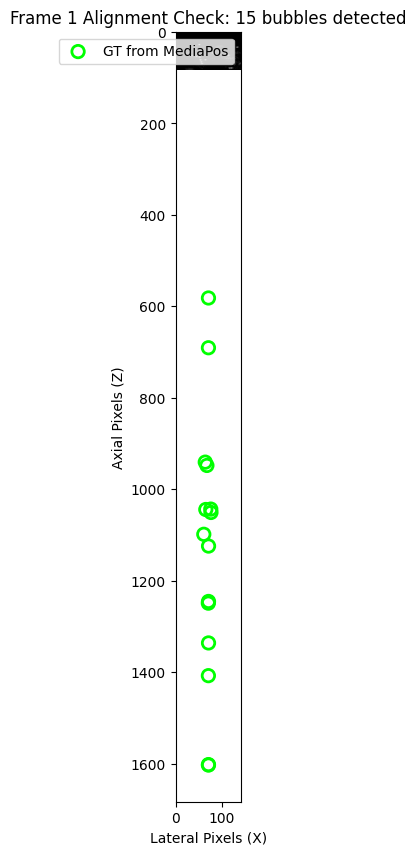

In [55]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

def verify_alignment_final(iq_file, pos_file):
    # 1. Load Image Data & Scaling
    iq_data = sio.loadmat(iq_file, squeeze_me=True)
    p_struct = iq_data['P']

    wavelength = p_struct['Wavelength'].item()
    start_depth = p_struct['startDepth'].item()
    samples_per_wave = p_struct['samplesPerWave'].item()

    dz = wavelength / samples_per_wave
    dx = wavelength

    # 2. Load Ground Truth
    gt_data = sio.loadmat(pos_file, squeeze_me=True)
    pos_cell_array = gt_data['MediaPos']

    # Since pos_cell_array[0] corresponds to Frame 1:
    frame_1_data = pos_cell_array[0] # This is the 2D matrix you shared

    # Extract columns from the Frame 1 matrix
    # Based on your output: Col 1 is X, Col 2 is Z
    f1_x_mm = frame_1_data[:, 1]
    f1_z_mm = frame_1_data[:, 2]

    # 3. Coordinate Transformation
    img_shape = iq_data['IQ'].shape # (Z_pixels, X_pixels, Frames)

    # Axial (Z): (Position - Offset) / Resolution
    bubble_z_px = (f1_z_mm - start_depth) / dz

    # Lateral (X): (Position / Resolution) + Half-Width-Offset
    # We add half the image width because 0mm is the center of the probe
    bubble_x_px = (f1_x_mm / dx) + (img_shape[1] / 2)

    # 4. Visualization
    # Envelope detection & Log Compression
    frame_img = np.abs(iq_data['IQ'][:, :, 0])
    img_log = 20 * np.log10(frame_img + 1e-6)

    plt.figure(figsize=(12, 10))
    # We show the top 40dB of signal
    plt.imshow(img_log, cmap='gray', vmin=np.max(img_log)-40)

    # Overlay the Ground Truth
    plt.scatter(bubble_x_px, bubble_z_px, s=80, edgecolors='#00FF00',
                facecolors='none', linewidths=2, label='GT from MediaPos')

    plt.title(f"Frame 1 Alignment Check: {len(f1_x_mm)} bubbles detected")
    plt.xlabel("Lateral Pixels (X)")
    plt.ylabel("Axial Pixels (Z)")
    plt.legend()
    plt.show()

# Execute
verify_alignment_final('/content/ulm_data/PALA_data_InSilicoFlow/IQ/PALA_InSilicoFlow_IQ001.mat',
                       '/content/ulm_data/PALA_data_InSilicoFlow/PALA_InSilicoFlow_v3_pos_MediaPos.mat')